In [19]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat
import sys, os

sys.path.append(os.path.abspath('../')) #to import hloc
from hloc import extract_features, match_features, localize_inloc, visualization

from matplotlib import cm
import random
import numpy as np
import pickle

from hloc.utils.read_write_model import read_images_binary, read_points3D_binary
from hloc.utils.viz import (
        plot_images, plot_keypoints, plot_matches, cm_RdGn, add_text)
from hloc.utils.io import read_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pipeline for indoor localization

## Setup
Here we declare the paths to the dataset, image pairs, and we choose the feature extractor and the matcher. You need to download the [InLoc dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/inloc/`, or change the path.

In [3]:
dataset = Path('../datasets/inloc_small_final/')  # change this if your dataset is somewhere else

pairs = Path('../pairs/inloc_small_final/')
loc_pairs = pairs / 'pairs-query-netvlad40-custom-shub-small.txt'  # top 40 retrieved by NetVLAD

outputs = Path('../outputs/inloc_small_final/feats-superpoint-n4096-r1600')  # where everything will be saved
results = outputs / 'InLoc_hloc_superpoint+superglue_netvlad40.txt'  # the result file

In [4]:
# list the standard configurations available
#print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
#print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

In [5]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs['superpoint_inloc']
matcher_conf = match_features.confs['superglue']

## Extract local features for database and query images

In [6]:
feature_path = extract_features.main(feature_conf, dataset, outputs)

[08/12/2021 12:17:51 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[08/12/2021 12:17:51 INFO] Found 500 images in root ../datasets/inloc_small_final.
Loaded SuperPoint model


  0%|          | 0/500 [00:00<?, ?it/s]/home/shubodh/anaconda3/envs/hloc/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 500/500 [01:54<00:00,  4.35it/s]

[08/12/2021 12:19:50 INFO] Finished exporting features.


## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [7]:
match_path = match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)

[08/12/2021 12:19:50 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 28/28 [00:33<00:00,  1.21s/it]

[08/12/2021 12:20:25 INFO] Finished exporting matches.


## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. Different from when localizing with Aachen, here we do not need a 3D SfM model here: the dataset already has 3D lidar scans. The file `InLoc_hloc_superpoint+superglue_netvlad40.txt` will contain the estimated query poses.

In [17]:
localize_inloc.main_only_kp(
    dataset, loc_pairs, feature_path, match_path, results,
    skip_matches=20)  # skip database images with too few matches

[08/12/2021 13:11:20 INFO] Starting localization...


100%|██████████| 1/1 [00:14<00:00, 14.67s/it]

[08/12/2021 13:11:34 INFO] Writing logs to ../outputs/inloc_small_final/feats-superpoint-n4096-r1600/InLoc_hloc_superpoint+superglue_netvlad40.txt_logs.pkl...
[08/12/2021 13:11:34 INFO] Done!


## Visualization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

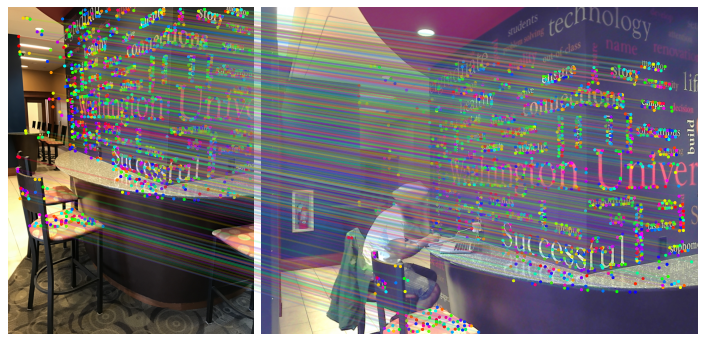

In [32]:
visualization.visualize_loc_kp(results, dataset, n=1, top_k_db=1, seed=2)